In [1]:
#create csv file for test
import os
import csv
img_dir="./test-resized"
with open('test-name.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    field = ["name"]
    writer.writerow(field)
    for x in os.listdir(img_dir):
        writer.writerow([x])

In [2]:
#Imports
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 1
2 torch.Size([3, 224, 224]) 1
3 torch.Size([3, 224, 224]) 0


/tmp/ipykernel_24767/725433756.py:86: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ./aten/src/ATen/native/TensorShape.cpp:3277.)
  plt.imshow(sample[0].T)


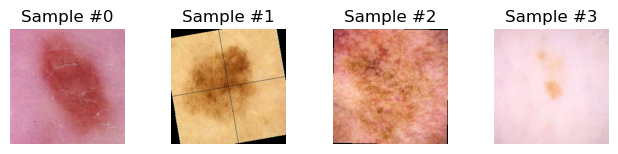

0 torch.Size([3, 224, 224]) 0
1 torch.Size([3, 224, 224]) 1
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


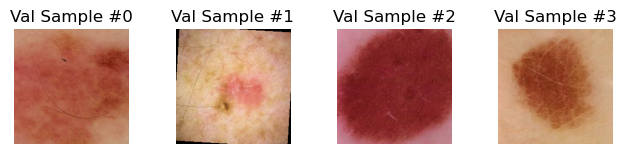

0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


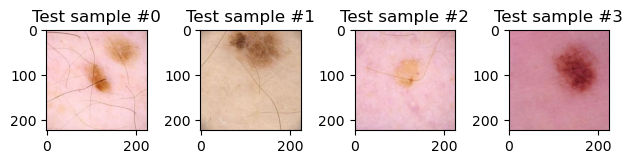

In [3]:
#Chargement des données
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+".jpg")
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class CustomImageTestset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_name = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name.iloc[idx,0])
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image
    
train_dataset=CustomImageDataset(annotations_file='./train-labels.csv',img_dir='./train-resized')

# Assuming train_dataset contains all data
total_size = len(train_dataset)

# Define data augmentation transforms
data_augmentation = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create an addtion class 1 from all data
class1_samples = [train_dataset[i] for i in range(total_size) if train_dataset[i][1] == 1]

# Apply data augmentation to class 1 samples and add to train_dataset
train_dataset += 10*[(data_augmentation(sample[0]), 1) for sample in class1_samples]
total_size = len(train_dataset)

# print(class1_samples)

# Calculate the size of the validation set (1/5 of the total size)
val_size = total_size // 5

# Calculate the size of the training set
train_size = total_size - val_size

# Use random_split to create datasets for training and validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset=CustomImageTestset(annotations_file='./test-name.csv',img_dir='./test-resized')

for i, sample in enumerate(train_dataset):
    print(i, sample[0].shape, sample[1])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break
        
for i, sample in enumerate(val_dataset):
    print(i, sample[0].shape, sample[1])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Val Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample[0].T)
    if i == 3:
        plt.show()
        break
        
for i, sample in enumerate(test_dataset):
    print(i, sample.shape)
    ay = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ay.set_title('Test sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample.T)
    if i == 3:
        plt.show()
        break

In [4]:
#Mise en forme des données

batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True,num_workers=2)

for X in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    #print(f"Shape of y: {y.shape} {y.dtype}")
    break
for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    print(f"batch:{batch_size}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
batch:64


In [5]:
# Création du modèle
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3*224*224, 512),
#             nn.ReLU(),
#             nn.Linear(512, 512),
#             nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = x.float()
        #print("Input data type:", x.dtype)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=150528, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [6]:
#défini la fonction de perte et l'optimiseur
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

In [7]:
#training
epochs=5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    size = len(train_dataset)
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
#         print(pred)
        
#         print("Target labels:", y)

        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
            
            # Validation
            
            val_loss = 0.0
            correct_predictions = 0
            total_samples = 0
            total_samples_0 = 0
            total_samples_1 = 0
            correct_predictions_0 = 0
            correct_predictions_1 = 0

            with torch.no_grad():
                model.eval()  # Set the model to evaluation mode
                for val_batch, (val_X, val_y) in enumerate(val_dataloader):
                    val_X, val_y = val_X.to(device), val_y.to(device)

                    val_pred = model(val_X)
                    val_loss += loss_fn(val_pred, val_y).item()

                    _, predicted_labels = torch.max(val_pred, 1)
                    correct_predictions_0 += ((val_y == 0) & (predicted_labels == 0)).sum().item()
                    correct_predictions_1 += ((val_y == 1) & (predicted_labels == 1)).sum().item()
                    
                    # Calculate accuracy for each class
                    total_samples_0 += (val_y == 0).sum().item()
                    total_samples_1 += (val_y == 1).sum().item()

            accuracy_0 = correct_predictions_0 / total_samples_0
            accuracy_1 = correct_predictions_1 / total_samples_1

            avg_val_loss = val_loss / (val_batch + 1)
            print(f"Validation loss: {avg_val_loss:.4f}")
            # Display class-wise accuracy
            print(f"        Accuracy for class 0: {accuracy_0:.4f}    class 1: {accuracy_1:.4f}")
            print()
            
    
print("Done!")
    



Epoch 1
-------------------------------
loss: 7.345556  [   64/31173]
Validation loss: 6.4040
        Accuracy for class 0: 0.9359    class 1: 0.0646

loss: 3.020267  [ 6464/31173]
Validation loss: 2.5027
        Accuracy for class 0: 0.8038    class 1: 0.2895

loss: 1.429459  [12864/31173]
Validation loss: 1.3978
        Accuracy for class 0: 0.9540    class 1: 0.4137

loss: 0.738016  [19264/31173]
Validation loss: 1.4184
        Accuracy for class 0: 0.7482    class 1: 0.7506

loss: 1.182882  [25664/31173]
Validation loss: 0.7243
        Accuracy for class 0: 0.9522    class 1: 0.6803

Epoch 2
-------------------------------
loss: 1.341422  [   64/31173]
Validation loss: 0.6609
        Accuracy for class 0: 0.9315    class 1: 0.7351

loss: 0.204027  [ 6464/31173]
Validation loss: 0.6889
        Accuracy for class 0: 0.9860    class 1: 0.6672

loss: 0.406009  [12864/31173]
Validation loss: 0.5789
        Accuracy for class 0: 0.9236    class 1: 0.8119

loss: 0.282294  [19264/31173]
Va

In [8]:
# #test
# size = len(dataloader.dataset)
# num_batches = len(dataloader)
# model.eval()
# test_loss, correct = 0, 0
# with torch.no_grad():
#     for X, y in dataloader:
#         X, y = X.to(device), y.to(device)
#         pred = model(X)
#         test_loss += loss_fn(pred, y).item()
#         correct += (pred.argmax(1) == y).type(torch.float).sum().item()
# test_loss /= num_batches
# correct /= size
# print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")